In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Response Generation/')

In [2]:
import pandas as pd
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers

In [3]:
df = pd.read_csv('emotion-emotion_69k - emotion-emotion_69k.csv')

In [4]:
df.head(3)

,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN
2,2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,NaN,NaN


### df = df[:10000]

In [5]:
data = df[['empathetic_dialogues', 'labels']]

In [6]:
data.head(3)

,empathetic_dialogues,labels
0,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju..."
1,Customer :This was a best friend. I miss her.\...,Where has she gone?
2,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...


In [7]:
data.shape

(64636, 2)

In [8]:
data = data[:10000]

In [9]:
# Extracting dialogues and labels into separate lists
dialogues_list = data['empathetic_dialogues'].tolist()
labels_list = data['labels'].tolist()

In [10]:
#print(dialogues_list)

In [11]:
#print(labels_list)

In [12]:
# Remove 'Customer :' and '\nAgent :' from each string in the list
cleaned_dialogues_list = [str(dialogue).replace('Customer :', '').replace('\nAgent :', '') if not pd.isna(dialogue) else '' for dialogue in dialogues_list]

In [13]:
#print(cleaned_dialogues_list)

In [14]:
len(cleaned_dialogues_list)

10000

In [15]:
len(labels_list)

10000

In [16]:
sorted_ques = [cleaned_dialogues_list[i] for i in range(len(cleaned_dialogues_list)) if len(cleaned_dialogues_list[i]) < 15]

In [17]:
sorted_ans = [labels_list[i] for i in range(len(cleaned_dialogues_list)) if len(cleaned_dialogues_list[i]) < 15]

In [18]:
print(sorted_ques)

['What happened?', 'Hello', "I don'", 'What happened?', 'And then what?', 'good idea', 'Shame on them.', 'Why is that?', 'Over 100mph.', 'Did she land?', 'In the Fall.', 'I love Texas.', 'How much?', 'I expect an A.', 'How was it?', 'No I am not.', 'Do you study?', 'Who is she?', 'my birthday!', 'What happened?', 'A saturn', 'He is honestly', 'Yes a 4.0', 'I am a male.', 'Is it ok?', 'That is great.', 'That was noble', 'Yes', 'How come?', "That's funny.", 'Was it cold?', 'Was it cold?', 'yes', 'Entrance exam', "Don't we all", 'Hahaha indeed!', 'do what?', 'hi', 'hai,hello', 'hi', 'how are you', 'no real ', 'What stuff? ', 'oh no why?', 'oh noo', 'yes', 'Wish me luck!', 'How did it go?', 'Really', 'Tornado.', '', 'terrified', 'terrified', '', 'terrified', 'Literature', 'That sucks. ', 'Criminology', 'I am', 'Size 7', 'in general lol', 'Oh no. I', 'What happened?', 'hi', 'That is great.', 'Yep. It is!', "That's great!", 'Are you ok?', 'How come?', 'yeah much ', '3', 'What about 3?', '4',

In [19]:
print(sorted_ans)

['Got rejected from a place I wanted to work, not once but three times ', 'Hello! I am in such a good mood since I got my new home.', 'That is good, I am glad you have no regrets!', 'Imagine ,I requested a French fries ,but was served burger instead!', 'Its frustrating when I go from 24 an hour to 10 an hour because of his lies.', 'No problem I hope everything works out', 'It is bothering me a lot. This coworker is not competent and he spend this time making jokes on other people.', 'I had gained a little weight and got embarassed.', 'Wow! You are crazy, ha ha - i probably would have had a panic attack at 90MPH. :p', 'Yeah! It was just really fast and she went up really high!', 'That is really great! How does that make you feel?', 'Texas is a great place! But I can understand the need to want to be prepared.', 'It was enough that I was able to pay off my car and a lot of bills.', 'I hope you get it!', "Beforehand I was really nervous that I was gonna mess it up and make things awkward.

### Data Preprocess

In [20]:
import re

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

In [21]:
# Clean questions and answers
clean_ques = [clean_text(line) for line in sorted_ques]
clean_ans = [' '.join(clean_text(line).split()[:15]) for line in sorted_ans]

In [22]:
print(clean_ques)

['what happened', 'hello', 'i don', 'what happened', 'and then what', 'good idea', 'shame on them', 'why is that', 'over 100mph', 'did she land', 'in the fall', 'i love texas', 'how much', 'i expect an a', 'how was it', 'no i am not', 'do you study', 'who is she', 'my birthday', 'what happened', 'a saturn', 'he is honestly', 'yes a 40', 'i am a male', 'is it ok', 'that is great', 'that was noble', 'yes', 'how come', 'that is funny', 'was it cold', 'was it cold', 'yes', 'entrance exam', 'dont we all', 'hahaha indeed', 'do what', 'hi', 'haihello', 'hi', 'how are you', 'no real ', 'what stuff ', 'oh no why', 'oh noo', 'yes', 'wish me luck', 'how did it go', 'really', 'tornado', '', 'terrified', 'terrified', '', 'terrified', 'literature', 'that sucks ', 'criminology', 'i am', 'size 7', 'in general lol', 'oh no i', 'what happened', 'hi', 'that is great', 'yep it is', 'that is great', 'are you ok', 'how come', 'yeah much ', '3', 'what about 3', '4', 'i was afraid', 'what is that', 'i wish bu

In [23]:
print(clean_ans)

['got rejected from a place i wanted to work not once but three times', 'hello i am in such a good mood since i got my new home', 'that is good i am glad you have no regrets', 'imagine i requested a french fries but was served burger instead', 'its frustrating when i go from 24 an hour to 10 an hour because of', 'no problem i hope everything works out', 'it is bothering me a lot this coworker is not competent and he spend this', 'i had gained a little weight and got embarassed', 'wow you are crazy ha ha i probably would have had a panic attack at', 'yeah it was just really fast and she went up really high', 'that is really great how does that make you feel', 'texas is a great place but i can understand the need to want to be', 'it was enough that i was able to pay off my car and a lot', 'i hope you get it', 'beforehand i was really nervous that i was gonna mess it up and make things', 'me neither but i agree with your sentiment it is a great place to live', 'i do now i passed all of my

### Vocabulary

In [24]:
# Build vocabulary
word2count = {}
for line in clean_ques + clean_ans:
    for word in line.split():
        word2count[word] = word2count.get(word, 0) + 1

In [25]:
# Set threshold for word inclusion
thresh = 5
vocab = {}
word_num = 0

In [26]:
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1

# Add special tokens
vocab.update({'<PAD>': word_num, '<EOS>': word_num + 1, '<OUT>': word_num + 2, '<SOS>': word_num + 3})

inv_vocab = {v: k for k, v in vocab.items()}

In [27]:
# Convert sentences to sequences of indices
encoder_inp = [[vocab.get(word, vocab['<OUT>']) for word in line.split()] for line in clean_ques]
decoder_inp = [[vocab.get(word, vocab['<OUT>']) for word in ('<SOS> ' + line + ' <EOS>').split()] for line in clean_ans]

In [28]:
# Pad sequences
encoder_inp = pad_sequences(encoder_inp, 15, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 15, padding='post', truncating='post')

In [29]:
# Prepare decoder final output
decoder_final_output = pad_sequences([line[1:] for line in decoder_inp], 15, padding='post', truncating='post')

In [30]:
# Check for out of bounds indices
max_index = len(vocab) - 1
if np.max(decoder_final_output) > max_index:
    print(f"Error: Index {np.max(decoder_final_output)} out of bounds for vocabulary size {len(vocab)}")
else:
    # Convert to categorical
    decoder_final_output = to_categorical(decoder_final_output, len(vocab))
    print("Decoder final output shape:", decoder_final_output.shape)

Decoder final output shape: (194, 15, 105)


### Glove Embedding

In [31]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Glove Loaded!")

Glove Loaded!


In [32]:
embedding_dim = 50
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
# Denoising Autoencoder
input_seq = Input(shape=(15, embedding_dim))
encoded = Dense(32, activation='relu', activity_regularizer=regularizers.l2(1e-4))(input_seq)
decoded = Dense(embedding_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_seq, decoded)
encoder = Model(input_seq, encoded)

In [34]:
autoencoder.compile(optimizer='adam', loss='mse')

In [35]:
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

In [36]:
embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=len(vocab)+1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=15,
                              trainable=False))

In [37]:
encoder_input_embeddings = embedding_model.predict(encoder_inp)
decoder_input_embeddings = embedding_model.predict(decoder_inp)

7/7 [==============================] - 0s 4ms/step


In [38]:
noisy_encoder_input_embeddings = add_noise(encoder_input_embeddings)
noisy_decoder_input_embeddings = add_noise(decoder_input_embeddings)

In [39]:
autoencoder.fit(noisy_encoder_input_embeddings, encoder_input_embeddings,
                epochs=200, batch_size=2, shuffle=True, validation_split=0.2)

Epoch 1/200
78/78 [==============================] - 3s 14ms/step - loss: 0.6360 - val_loss: 0.4768
Epoch 2/200
78/78 [==============================] - 1s 11ms/step - loss: 0.4197 - val_loss: 0.3994
Epoch 3/200
78/78 [==============================] - 1s 12ms/step - loss: 0.3861 - val_loss: 0.3814
Epoch 4/200
78/78 [==============================] - 1s 11ms/step - loss: 0.3720 - val_loss: 0.3706
Epoch 5/200
78/78 [==============================] - 1s 10ms/step - loss: 0.3633 - val_loss: 0.3638
Epoch 6/200
78/78 [==============================] - 1s 11ms/step - loss: 0.3578 - val_loss: 0.3592
Epoch 7/200
78/78 [==============================] - 0s 5ms/step - loss: 0.3540 - val_loss: 0.3560
Epoch 8/200
78/78 [==============================] - 0s 5ms/step - loss: 0.3513 - val_loss: 0.3537
Epoch 9/200
78/78 [==============================] - 0s 5ms/step - loss: 0.3492 - val_loss: 0.3519
Epoch 10/200
78/78 [==============================] - 0s 4ms/step - loss: 0.3476 - val_loss: 0.3504
Epo

In [40]:
encoder_inp_encoded = encoder.predict(encoder_input_embeddings)
decoder_inp_encoded = encoder.predict(decoder_input_embeddings)

7/7 [==============================] - 0s 3ms/step


In [41]:
# Main Model
enc_inp = Input(shape=(15, 32))
dec_inp = Input(shape=(15, 32))

enc_lstm = Bidirectional(LSTM(32, return_state=True, dropout=0.3, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_inp)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
enc_states = [state_h, state_c]

dec_lstm = LSTM(32 * 2, return_state=True, return_sequences=True, dropout=0.3)
output, _, _ = dec_lstm(dec_inp, initial_state=enc_states)

dec_dense = Dense(len(vocab), activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
final_output = dec_dense(output)

model = Model([enc_inp, dec_inp], final_output)

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Training the main model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit([encoder_inp_encoded, decoder_inp_encoded], decoder_final_output,
                    epochs=100, batch_size=2, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
78/78 [==============================] - 11s 39ms/step - loss: 3.1787 - accuracy: 0.3746 - val_loss: 2.6018 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 1s 16ms/step - loss: 2.5864 - accuracy: 0.4482 - val_loss: 2.5598 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 1s 17ms/step - loss: 2.5130 - accuracy: 0.4649 - val_loss: 2.4555 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 1s 16ms/step - loss: 2.4502 - accuracy: 0.4748 - val_loss: 2.4323 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 1s 16ms/step - loss: 2.4024 - accuracy: 0.4882 - val_loss: 2.3864 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 1s 17ms/step - loss: 2.3727 - accuracy: 0.4929 - val_loss: 2.3935 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 1s 17ms/step - l

In [44]:
model.save('chatbot.keras')
model.save_weights('chatbot_weights.keras')

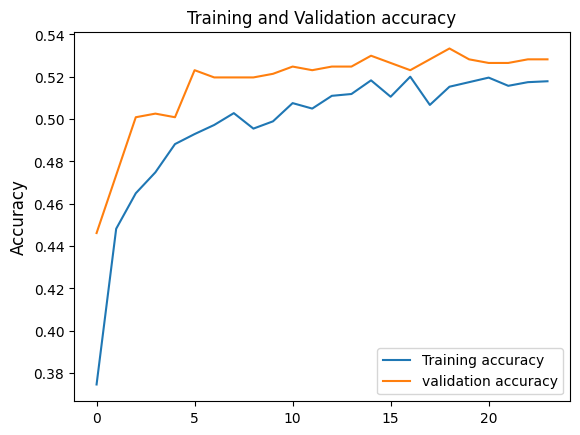

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title("Training and Validation accuracy")
plt.ylabel('Accuracy', fontsize="large")
plt.legend(['Training accuracy','validation accuracy'])
plt.show()

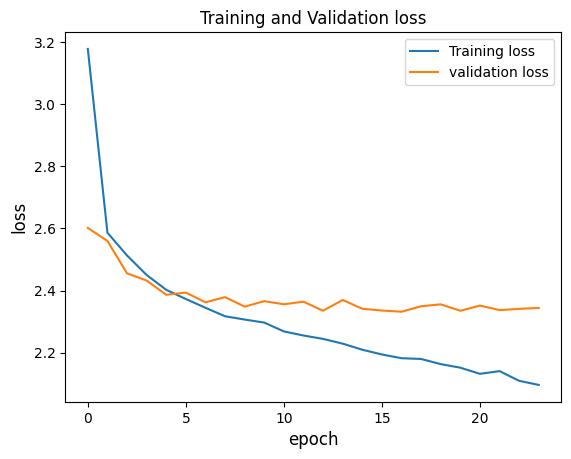

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(['Training loss','validation loss'])
plt.show()

In [47]:
!pip install evaluate

In [48]:
# Predict using the trained model
predictions = model.predict([encoder_inp_encoded, decoder_inp_encoded])
# Assuming predictions are one-hot encoded, convert them to class labels
predicted_labels = np.argmax(predictions, axis=2)

7/7 [==============================] - 2s 14ms/step


In [49]:
# Compute BLEU score
# Convert integer sequences back to sentences
def sequences_to_texts(sequences, inv_vocab):
    texts = []
    for sequence in sequences:
        text = ' '.join([inv_vocab[i] for i in sequence if i != 0])
        texts.append(text)
    return texts

predicted_texts = sequences_to_texts(predicted_labels, inv_vocab)
true_texts = sequences_to_texts(np.argmax(decoder_final_output, axis=2), inv_vocab)

In [50]:
import evaluate

# Load the BLEU evaluation metric
bleu = evaluate.load("bleu")

# Compute the BLEU score
results1 = bleu.compute(predictions=predicted_texts, references=true_texts)

# Print the results
print(results1)

{'bleu': 0.2671274821244883, 'precisions': [0.4516945851188157, 0.3299595141700405, 0.23999157184997894, 0.14235500878734622], 'brevity_penalty': 1.0, 'length_ratio': 1.456867196367764, 'translation_length': 5134, 'reference_length': 3524}


In [51]:
from sklearn.metrics import jaccard_score
import numpy as np

# Function to compute Jaccard index for individual pairs of texts
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Convert texts to sets of words
predicted_sets = [set(text.split()) for text in predicted_texts]
true_sets = [set(text.split()) for text in true_texts]

# Compute Jaccard indices for all pairs
jaccard_indices = [jaccard_index(pred, true) for pred, true in zip(predicted_sets, true_sets)]

# Average Jaccard index
average_jaccard_index = np.mean(jaccard_indices)

print("Average Jaccard Index:", average_jaccard_index)

Average Jaccard Index: 0.2045136993590602


In [52]:
# Assuming you have the model and test data ready
test_loss, _ = model.evaluate([encoder_inp_encoded, decoder_inp_encoded], decoder_final_output)
perplexity = np.exp(test_loss)
print("Perplexity:", perplexity)

7/7 [==============================] - 0s 19ms/step - loss: 2.1558 - accuracy: 0.5206
Perplexity: 8.634590284882668


In [53]:
!pip install rouge

In [54]:
from rouge import Rouge

# Assuming you have predicted and true texts as lists of strings
rouge = Rouge()
scores = rouge.get_scores(predicted_texts, true_texts, avg=True)
print("ROUGE Scores:", scores)

ROUGE Scores: {'rouge-1': {'r': 0.21262556172350003, 'p': 0.8092783505154639, 'f': 0.3266172227853669}, 'rouge-2': {'r': 0.08701147077435735, 'p': 0.41494845360824745, 'f': 0.13908479676659982}, 'rouge-l': {'r': 0.19937871406943583, 'p': 0.7525773195876289, 'f': 0.30524967280956977}}
